In [1]:
%pylab inline
import time

import pandas as pd
import anndata

import torch

from scvi.dataset import GeneExpressionDataset
from scvi.models import LDVAE
from scvi.inference import UnsupervisedTrainer
from scvi.inference.posterior import Posterior

Populating the interactive namespace from numpy and matplotlib


In [2]:
adata = anndata.read('cao_atlas.h5ad')

In [3]:
# idx = np.random.choice(adata.obs.query('detected_doublet == "False"').index, 100000, replace=False)
idx = adata.obs.query('detected_doublet == "False"').index

In [4]:
cell_numbers = [2500 * 2 ** i for i in range(10)] + [idx.shape[0]]

In [5]:
s_adata = adata[idx]

In [6]:
X, local_means, local_vars, batch_indices, labels = \
GeneExpressionDataset.get_attributes_from_matrix(s_adata.X)

In [7]:
def create_dataset():
    cells_dataset = \
    GeneExpressionDataset(X, local_means, local_vars, batch_indices, labels,
                      gene_names=np.array(s_adata.var.index.values, dtype=str))
    return cells_dataset

In [8]:
inference_times = []
train_histories = []
for n_cells in cell_numbers:
    cells_dataset = create_dataset()
    cells_dataset.subsample_cells(n_cells)
    cells_dataset.subsample_genes(1000)
    
    vae = LDVAE(cells_dataset.nb_genes,
            n_layers=1,
            n_hidden=128,
            reconstruction_loss='nb'
           )
    
    trainer = UnsupervisedTrainer(vae,
                              cells_dataset,
                              frequency=1,
                              use_cuda=True
                             )
    
    t0 = time.time()
    trainer.train(n_epochs=10)
    t = time.time() - t0
    
    inference_times.append(t)
    train_histories.append(trainer.history['ll_train_set'])
    

Downsampling from 1949131 to 2500 cells
Downsampling from 26183 to 1000 genes
Downsampling from 2500 to 2500 cells
training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s]
Downsampling from 1949131 to 5000 cells
Downsampling from 26183 to 1000 genes
Downsampling from 5000 to 5000 cells
training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]
Downsampling from 1949131 to 10000 cells
Downsampling from 26183 to 1000 genes
Downsampling from 10000 to 10000 cells
training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]
Downsampling from 1949131 to 20000 cells
Downsampling from 26183 to 1000 genes
Downsampling from 20000 to 20000 cells
training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.59s/it]
Downsampling from 1949131 to 40000 cells
Downsampling 

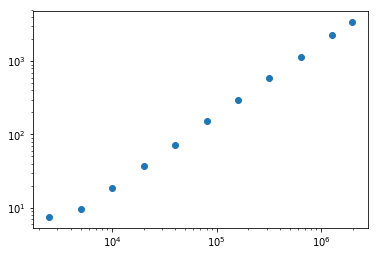

In [9]:
plt.loglog()
plt.scatter(cell_numbers, inference_times);

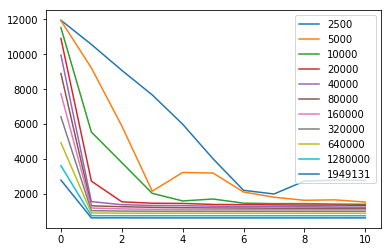

In [10]:
for n, th in zip(cell_numbers, train_histories):
    plt.plot(th, label=n)
    
plt.legend();

In [11]:
inference_times_cpu = []
train_histories_cpu = []
for n_cells in cell_numbers:
    cells_dataset = create_dataset()
    cells_dataset.subsample_cells(n_cells)
    cells_dataset.subsample_genes(1000)
    
    vae = LDVAE(cells_dataset.nb_genes,
            n_layers=1,
            n_hidden=128,
            reconstruction_loss='nb'
           )
    
    trainer = UnsupervisedTrainer(vae,
                              cells_dataset,
                              frequency=1,
                              use_cuda=False
                             )
    
    t0 = time.time()
    trainer.train(n_epochs=10)
    t = time.time() - t0
    
    inference_times_cpu.append(t)
    

Downsampling from 1949131 to 2500 cells
Downsampling from 26183 to 1000 genes
Downsampling from 2500 to 2500 cells
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]
Downsampling from 1949131 to 5000 cells
Downsampling from 26183 to 1000 genes
Downsampling from 5000 to 5000 cells
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]
Downsampling from 1949131 to 10000 cells
Downsampling from 26183 to 1000 genes
Downsampling from 10000 to 10000 cells
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.48s/it]
Downsampling from 1949131 to 20000 cells
Downsampling from 26183 to 1000 genes
Downsampling from 20000 to 20000 cells
training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████

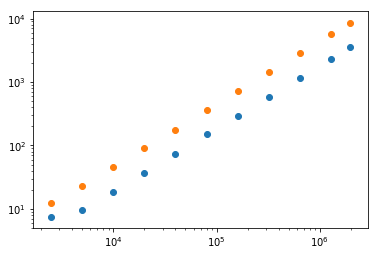

In [12]:
plt.loglog()
plt.scatter(cell_numbers, inference_times);
plt.scatter(cell_numbers, inference_times_cpu);

In [13]:
infer_time_df = \
pd.DataFrame({'cell_numbers': cell_numbers,
              'gpu_inference_time': inference_times,
              'cpu_inference_time': inference_times_cpu})

In [14]:
infer_time_df.to_csv('linear_inference_times.csv')

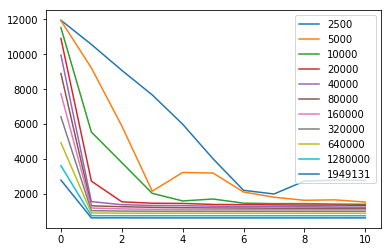

In [15]:
for n, th in zip(cell_numbers, train_histories):
    plt.plot(th, label=n)
    
plt.legend();

In [16]:
train_h_df = pd.DataFrame(np.array(train_histories), index=cell_numbers)

In [17]:
train_h_df.to_csv('linear_train_history.csv')